In [3]:
import os
import shutil
import math
import numpy as np
from IPython.display import Video
from omegaconf import OmegaConf
from tqdm import tqdm
from gymnasium.utils.save_video import save_video
import torch
from torch.utils.data import Dataset, DataLoader
from tensordict import TensorDict
from torchrl.envs import EnvBase
from torchrl.data import ReplayBuffer, LazyTensorStorage, SamplerWithoutReplacement
from matplotlib import pyplot as plt
from guided_diffusion.script_util import create_classifier, classifier_defaults
from diffusion_co_design.pretrain.rware.transform import storage_to_layout
from rware.warehouse import Warehouse
from diffusion_co_design.rware.env import create_env, create_batched_env
from diffusion_co_design.rware.model import rware_models
from diffusion_co_design.utils import (
    omega_to_pydantic,
    get_latest_model,
    cuda,
    OUTPUT_DIR,
)
from diffusion_co_design.pretrain.rware.transform import storage_to_layout
from diffusion_co_design.bin.train_rware import (
    TrainingConfig,
    DesignerRegistry,
    DesignerConfig,
)
from diffusion_co_design.pretrain.rware.generator import (
    Generator,
    OptimizerDetails,
)

FIGURE_SIZE_CNST = 3
CACHE_ID = "train_visualisation"
RECOMPUTE = False

# Parameters
# training_dir = "/home/markhaoxiang/.diffusion_co_design/training/2025-02-23/21-11-20"  # Random
training_dir = "/home/markhaoxiang/.diffusion_co_design/training/2025-03-16/03-55-12"  # Four corners

device = cuda

# Get latest policy
checkpoint_dir = os.path.join(training_dir, "checkpoints")
latest_policy = get_latest_model(checkpoint_dir, "policy_")

# Get config
hydra_dir = os.path.join(training_dir, ".hydra")
training_config = os.path.join(hydra_dir, "config.yaml")
cfg = omega_to_pydantic(OmegaConf.load(training_config), TrainingConfig)

# Create environment
cache_dir = os.path.join(OUTPUT_DIR, ".tmp", CACHE_ID)
if RECOMPUTE and os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)


master_designer, env_designer = DesignerRegistry.get(
    DesignerConfig(type="random"),
    cfg.scenario,
    cache_dir,
    environment_batch_size=32,
    device=device,
)
agent_idxs = cfg.scenario.agent_idxs
goal_idxs = cfg.scenario.goal_idxs
env = create_env(cfg.scenario, env_designer, render=True, device=device)
policy, _ = rware_models(env, cfg.policy, device=device)
policy.load_state_dict(torch.load(latest_policy))


def view_video(env: EnvBase, policy):
    frames = []
    video_out = os.path.join(cache_dir, "video/rl-video-episode-0.mp4")

    def append_frames(env, td):
        return frames.append(env.render())

    env.rollout(
        max_steps=cfg.scenario.max_steps,
        policy=policy,
        callback=append_frames,
        auto_cast_to_device=True,
    )

    save_video(
        frames=frames,
        video_folder=os.path.join(cache_dir, "video"),
        fps=10,
    )

    return lambda: Video(filename=video_out, embed=True)

/home/markhaoxiang/Projects/part-iii-project/diffusion-co-design/packages/robotic-warehouse/rware/warehouse.py:137: UserWarning: Provided layout agents 5 does not match n_agents 3.
  warnings.warn(
/home/markhaoxiang/Projects/part-iii-project/diffusion-co-design/.venv/lib/python3.11/site-packages/torchrl/envs/common.py:1105: DeprecationWarning: You are querying a non-trivial, single action_spec, i.e., there is only one action known by the environment but it is not named `'action'`. Currently, env.action_spec returns the leaf but for consistency with the setter, this will return the full spec instead (from v0.8 and on).
  warnings.warn(


In [4]:
# Test if the value function is able to discern good environments!

NUM_PARALLEL_COLLECTION = 25
DATASET_SIZE = 10_000
# DATASET_SIZE = 4
BATCH_SIZE = 128
TEST_PROPORTION = 0.2

collection_env = create_batched_env(
    num_environments=NUM_PARALLEL_COLLECTION,
    scenario=cfg.scenario,
    designer=env_designer,
    is_eval=False,
    device="cpu",
)

env_returns = ReplayBuffer(
    storage=LazyTensorStorage(max_size=DATASET_SIZE),
    sampler=SamplerWithoutReplacement(),
    batch_size=BATCH_SIZE,
)


if RECOMPUTE:
    for _ in tqdm(range(DATASET_SIZE // NUM_PARALLEL_COLLECTION)):
        rollout = collection_env.rollout(
            max_steps=cfg.scenario.max_steps, policy=policy, auto_cast_to_device=True
        )
        done = rollout.get(("next", "done"))
        X = rollout.get("state")[done.squeeze()]
        y = rollout.get(("next", "agents", "episode_reward")).mean(-2)[done]
        data = TensorDict({"env": X, "episode_reward": y}, batch_size=len(y))
        env_returns.extend(data)
    del rollout, done

env_returns_path = os.path.join(cache_dir, "env_returns")
if RECOMPUTE:
    env_returns.dumps(env_returns_path)
else:
    env_returns.loads(env_returns_path)


class EnvReturnsDataset(Dataset):
    def __init__(self, env_returns):
        self.env_returns = env_returns

    def __len__(self):
        return len(self.env_returns)

    def __getitem__(self, idx):
        sample = self.env_returns[idx]
        X = sample.get("env").to(dtype=torch.float32, device=device)
        y = sample.get("episode_reward").to(dtype=torch.float32, device=device)
        return X, y


env_returns_dataset = EnvReturnsDataset(env_returns)

train_size = int(0.8 * len(env_returns))
eval_size = len(env_returns) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(
    env_returns_dataset, [train_size, eval_size]
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
GUIDANCE_WT = 50
TRAIN_NUM_EPOCHS = 80
# VALUE_LR = 3e-4
VALUE_LR = 3e-5
VALUE_WEIGHT_DECAY = 0.05
RECOMPUTE = False
USE_GOAL_MAP = False

ITERATIONS_PER_EPOCH = math.ceil(DATASET_SIZE / BATCH_SIZE)

goal_map = np.zeros((cfg.scenario.n_colors, cfg.scenario.size, cfg.scenario.size))
for goal, color in zip(cfg.scenario.goal_idxs, cfg.scenario.goal_colors):
    goal_map[color, goal // cfg.scenario.size, goal % cfg.scenario.size] = 1
goal_map = (
    torch.from_numpy(goal_map).to(device=device, dtype=torch.float32).unsqueeze(0)
)

# Create value model
pretrain_dir = os.path.join(OUTPUT_DIR, "diffusion_pretrain", cfg.scenario.name)
latest_checkpoint = get_latest_model(pretrain_dir, "model")


generator = Generator(
    batch_size=8,
    generator_model_path=latest_checkpoint,
    size=cfg.scenario.size,
    num_channels=cfg.scenario.n_colors,
    guidance_wt=GUIDANCE_WT,
)

model_dict = classifier_defaults()
model_dict["image_size"] = cfg.scenario.size
model_dict["image_channels"] = (
    cfg.scenario.n_colors * 2 if USE_GOAL_MAP else cfg.scenario.n_colors
)

model_dict["classifier_width"] = 128
model_dict["classifier_depth"] = 2
model_dict["classifier_attention_resolutions"] = "16, 8, 4"
model_dict["output_dim"] = 1

model = create_classifier(**model_dict).to(device)

# Train
optim = torch.optim.Adam(
    model.parameters(), lr=VALUE_LR, weight_decay=VALUE_WEIGHT_DECAY
)
criterion = torch.nn.MSELoss()


if RECOMPUTE:
    train_losses = []
    eval_losses = []
    with tqdm(range(TRAIN_NUM_EPOCHS)) as pbar:
        for epoch in range(TRAIN_NUM_EPOCHS):
            running_train_loss = 0
            model.train()
            for X_batch, y_batch in train_loader:
                optim.zero_grad()
                X_batch = X_batch.to(dtype=torch.float32, device=device)
                y_batch = y_batch.to(dtype=torch.float32, device=device)

                # Add goal map
                if USE_GOAL_MAP:
                    goal_map_batch = goal_map.expand(X_batch.shape[0], -1, -1, -1)
                    X_batch = torch.cat([X_batch, goal_map_batch], dim=1)

                # Normalisation
                X_batch = X_batch * 2 - 1
                # t, _ = generator.schedule_sampler.sample(X_batch.shape[0], device)
                # X_batch = generator.diffusion.q_sample(X_batch, t)
                y_pred = model(X_batch).squeeze()
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optim.step()

                running_train_loss += loss.item()
            running_train_loss = running_train_loss / len(train_loader)

            # Evaluate
            model.eval()
            running_eval_loss = 0
            with torch.no_grad():
                for X_batch, y_batch in eval_loader:
                    X_batch = X_batch.to(dtype=torch.float32, device=device)
                    y_batch = y_batch.to(dtype=torch.float32, device=device)

                    # Add goal map
                    if USE_GOAL_MAP:
                        goal_map_batch = goal_map.expand(X_batch.shape[0], -1, -1, -1)
                        X_batch = torch.cat([X_batch, goal_map_batch], dim=1)

                    # Normalisation
                    X_batch = X_batch * 2 - 1

                    y_pred = model(X_batch).squeeze()
                    loss = criterion(y_pred, y_batch)

                    running_eval_loss += loss.item()
            running_eval_loss = running_eval_loss / len(eval_loader)

            train_losses.append(running_train_loss)
            eval_losses.append(running_eval_loss)
            pbar.set_description(
                f" Train Loss {running_train_loss} Eval Loss {running_eval_loss}"
            )
            pbar.update()

    torch.save(model.state_dict(), "train_visualisation_classifier.pt")
else:
    model.load_state_dict(torch.load("train_visualisation_classifier.pt"))

In [ ]:
plt.plot(train_losses)
plt.plot(eval_losses)
plt.title("Value Function loss")
min(train_losses)

In [ ]:
torch.cuda.empty_cache()

env_returns_sorted_index = torch.argsort(eval_dataset[:][1], descending=True)
# env_returns_sorted_index = torch.argsort(
#     env_returns.storage["episode_reward"], descending=True
# )
best_5 = env_returns_sorted_index[:5]
worst_5 = env_returns_sorted_index[-5:]

fig, axs = plt.subplots(2, 5)
fig.set_size_inches(5 * FIGURE_SIZE_CNST, 2 * FIGURE_SIZE_CNST)

for i, idx in enumerate(best_5):
    ax = axs[0, i]
    layout = storage_to_layout(
        # env_returns.storage["env"][idx],
        eval_dataset[:][0][idx].numpy(force=True),
        cfg.scenario.agent_idxs,
        cfg.scenario.goal_idxs,
        cfg.scenario.goal_colors,
    )
    print(eval_dataset[:][1][idx])
    warehouse = Warehouse(layout=layout, render_mode="rgb_array")
    im = warehouse.render()
    ax.imshow(im)
    warehouse.close()
    ax.axis("off")

print("===")

for i, idx in enumerate(worst_5):
    ax = axs[1, i]
    layout = storage_to_layout(
        # env_returns.storage["env"][idx],
        eval_dataset[:][0][idx].numpy(force=True),
        cfg.scenario.agent_idxs,
        cfg.scenario.goal_idxs,
        cfg.scenario.goal_colors,
    )
    print(eval_dataset[:][1][idx])
    warehouse = Warehouse(layout=layout, render_mode="rgb_array")
    im = warehouse.render()
    ax.imshow(im)
    warehouse.close()
    ax.axis("off")

In [ ]:
torch.cuda.empty_cache()
N = 50

model.eval()
# good_envs = env_returns.storage["env"][env_returns_sorted_index[:N]].to(
good_envs = eval_dataset[:][0][env_returns_sorted_index[:N]].to(
    device=device, dtype=torch.float32
)
# goal_map_batch = goal_map.expand(good_envs.shape[0], -1, -1).unsqueeze(1)
# good_envs = torch.cat([good_envs, goal_map_batch], dim=1)
print(f"Good environments: {model(good_envs * 2 - 1).mean()}")

bad_envs = eval_dataset[:][0][env_returns_sorted_index[-N:]].to(
    device=device, dtype=torch.float32
)
# bad_envs = torch.cat([bad_envs, goal_map_batch], dim=1)
print(f"Bad environments: {model(bad_envs * 2 - 1).mean()}")

del good_envs
del bad_envs

52
53
51
50
50
49
54
52
tensor([[10.4532],
        [10.6191],
        [10.5448],
        [10.5881],
        [10.4303],
        [10.6713],
        [10.3094],
        [10.1107]], device='cuda:0', grad_fn=<SelectBackward0>)


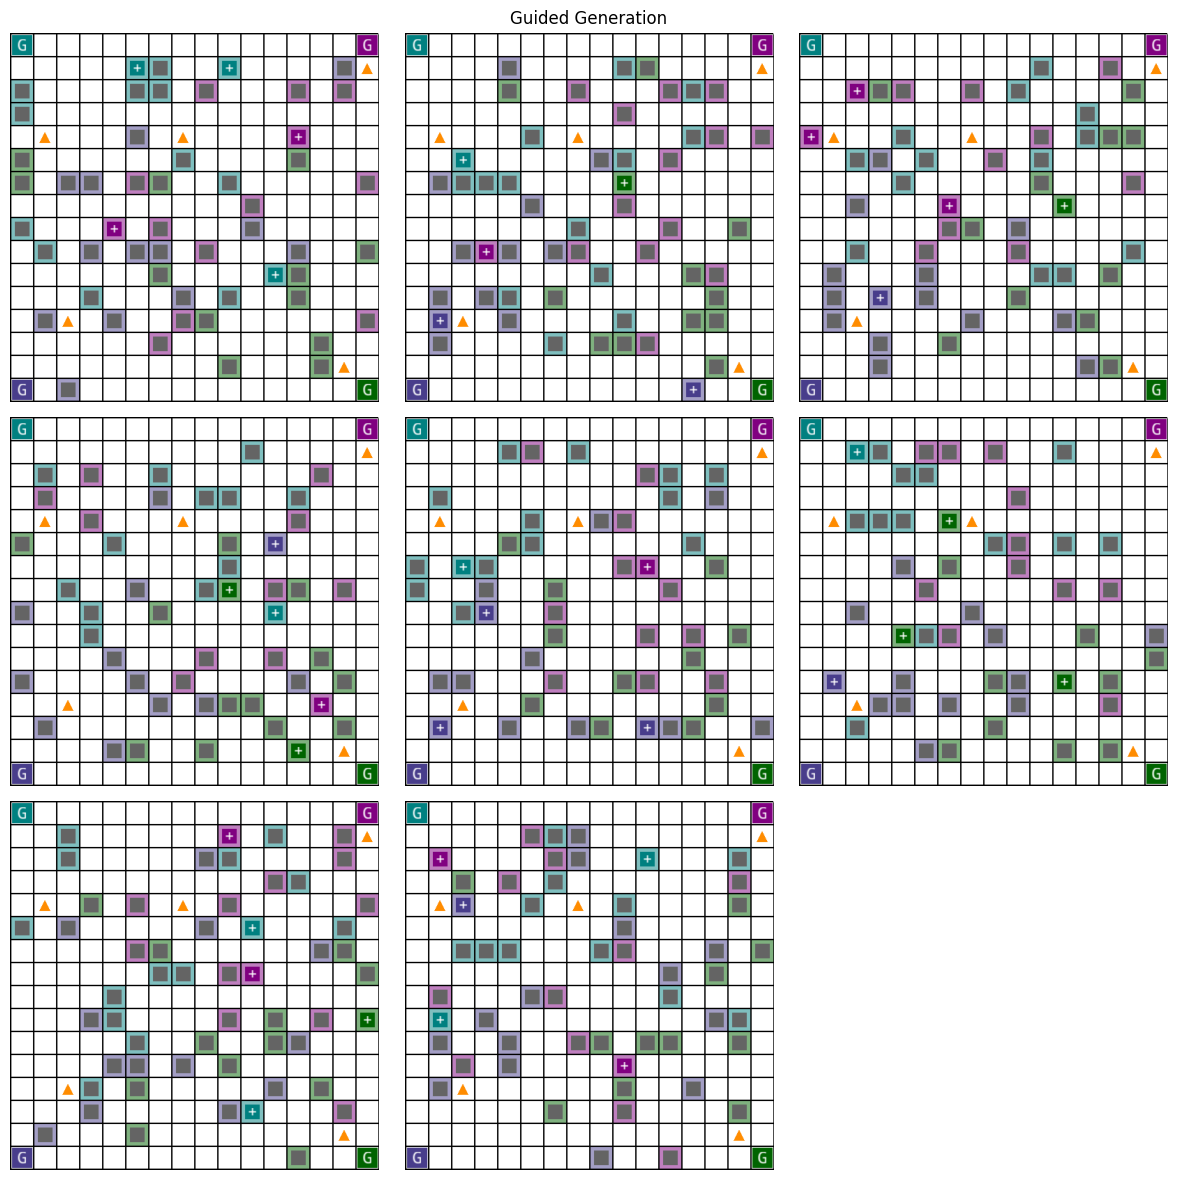

In [8]:
generator = Generator(
    batch_size=8,
    generator_model_path=latest_checkpoint,
    size=cfg.scenario.size,
    num_channels=cfg.scenario.n_colors,
    guidance_wt=200,
)
model.eval()
operation = OptimizerDetails()
operation.num_recurrences = 4
operation.backward_steps = 0
# operation.operated_image = goal_map * 2 - 1


def show_batch(environment_batch, n: int = 8):
    layouts = []
    for image in environment_batch:
        layout = storage_to_layout(
            image, agent_idxs, goal_idxs, cfg.scenario.goal_colors
        )
        warehouse = Warehouse(layout=layout, render_mode="rgb_array")
        layouts.append(warehouse.render())
        warehouse.close()

    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    axs = axs.ravel()
    for ax in axs:
        ax.axis("off")
    for i in range(n):
        axs[i].imshow(layouts[i])
    return fig, axs


environment_batch = generator.generate_batch(
    value=model,
    use_operation=True,
    operation_override=operation,
)


for env in environment_batch:
    layout = storage_to_layout(
        env, cfg.scenario.agent_idxs, cfg.scenario.goal_idxs, cfg.scenario.goal_colors
    )
    print(len(layout.reset_shelves()))
fig, axs = show_batch(environment_batch)
fig.suptitle("Guided Generation")
fig.tight_layout()

X_batch = (
    torch.from_numpy(environment_batch).to(device=device, dtype=torch.float32)
    # .moveaxis((0, 1, 2, 3), (0, 2, 3, 1))
)
# X_batch = torch.cat([X_batch, goal_map.unsqueeze(0).expand(8, -1, -1, -1)], dim=1)
X_batch = (X_batch * 2) - 1
print(model(X_batch))

In [6]:
model = create_classifier(**model_dict).to(device)
latest_classifier = get_latest_model(checkpoint_dir, "designer_")
model.load_state_dict(torch.load(latest_classifier))

<All keys matched successfully>

In [9]:
generator = Generator(
    batch_size=8,
    generator_model_path=latest_checkpoint,
    size=cfg.scenario.size,
    num_channels=cfg.scenario.n_colors,
    guidance_wt=200,
)
model.eval()
operation = OptimizerDetails()
operation.num_recurrences = 8
operation.backward_steps = 0

generated_envs = []
generator = Generator(
    batch_size=50,
    generator_model_path=latest_checkpoint,
    size=cfg.scenario.size,
    num_channels=cfg.scenario.n_colors,
    guidance_wt=200,
)
for _ in tqdm(range(20)):
    environment_batch = generator.generate_batch(
        value=model, use_operation=True, operation_override=operation
    )
    generated_envs.extend(environment_batch)

100%|██████████| 20/20 [13:21<00:00, 40.07s/it]


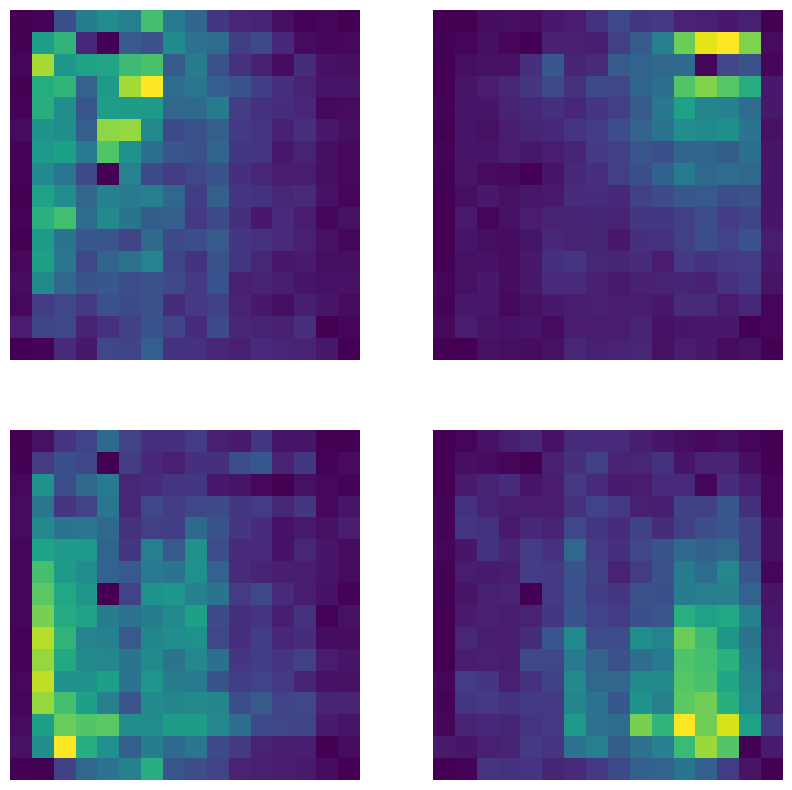

In [11]:
generated_envs_numpy = np.array(generated_envs)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        s = generated_envs_numpy.sum(axis=0)
        axs[i, j].imshow(s[i * 2 + j])
        axs[i, j].axis("off")
plt.show()

tensor([10.7333, 10.7317, 10.7314, 10.7281, 10.7227, 10.7215, 10.7212, 10.7188,
        10.7182], device='cuda:0', grad_fn=<IndexBackward0>)
9.401420593261719 10.733301162719727 0.17106352746486664
49
50
50
50
49
50
50
51
51


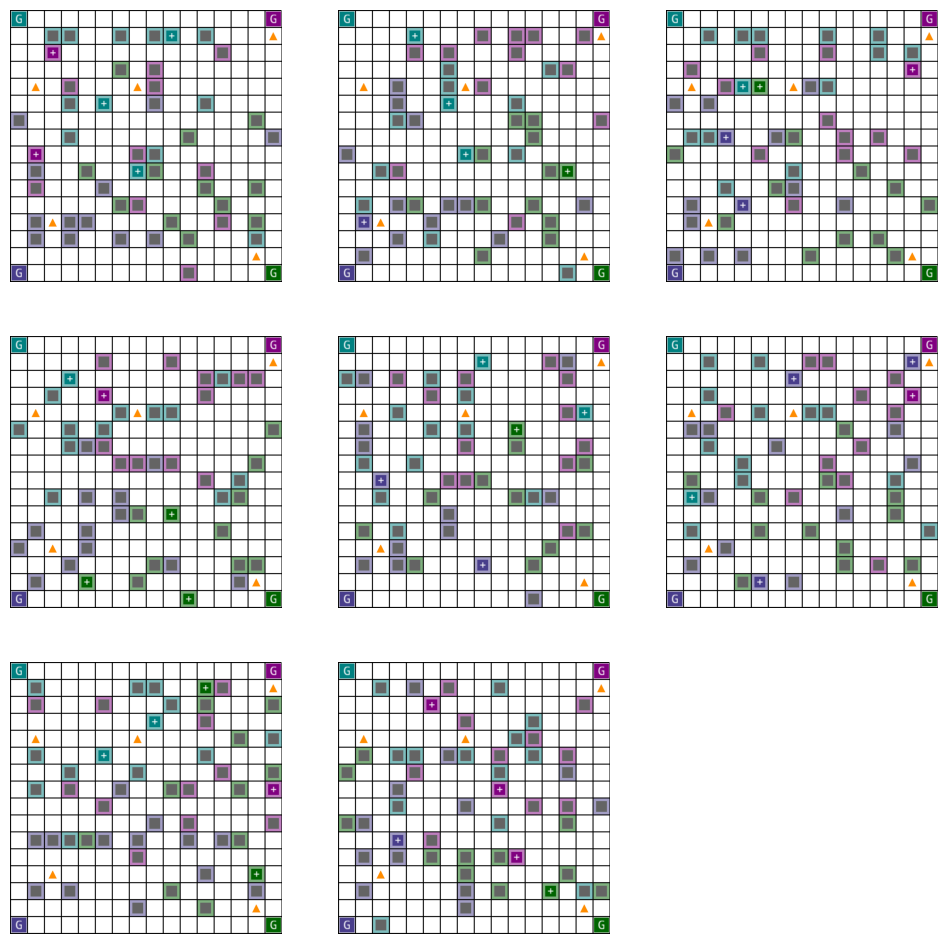

In [25]:
# Get best 9 environments using the classifier
model.eval()
X_batch = torch.from_numpy(generated_envs_numpy).to(device=device, dtype=torch.float32)
X_batch = (X_batch * 2) - 1  # Normalize the input
scores = model(X_batch).squeeze()
best_9_indices = torch.topk(scores, 9).indices
generated_envs_numpy_best = generated_envs_numpy[best_9_indices.cpu().numpy()]
print(scores[best_9_indices])

print(scores.min().item(), scores.max().item(), scores.std().item())

for env in generated_envs_numpy_best:
    layout = storage_to_layout(
        env, cfg.scenario.agent_idxs, cfg.scenario.goal_idxs, cfg.scenario.goal_colors
    )
    print(len(layout.reset_shelves()))
fig, axs = show_batch(generated_envs_numpy_best)

In [ ]:
plt.hist(generated_envs_numpy.sum(axis=0).flatten(), bins=50)
pass

In [ ]:
# Counterfactual: randomly generated environments

environment_batch = generator.generate_batch()


for env in environment_batch:
    layout = storage_to_layout(
        env, cfg.scenario.agent_idxs, cfg.scenario.goal_idxs, cfg.scenario.goal_colors
    )
    print(len(layout.reset_shelves()))
fig, axs = show_batch(environment_batch)
fig.suptitle("Guided Generation")
fig.tight_layout()

X_batch = (
    torch.from_numpy(environment_batch).to(device=device, dtype=torch.float32)
    # .moveaxis((0, 1, 2, 3), (0, 2, 3, 1))
)
# X_batch = torch.cat([X_batch, goal_map.unsqueeze(0).expand(8, -1, -1, -1)], dim=1)
X_batch = (X_batch * 2) - 1
print(model(X_batch))